# Clasificación de Autos usando SVM e histograma de color

El problema consiste en clasificar las imágenes en imágenes que contienen autos o en imágenes que no contienen autos, usando SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Se define 2 funciones de ayuda para extraer características de las imágenes ("preprocesamiento"):
* hsv_hist: calcula el histograma de HSV (tamaño: nbins*3)
* extract_hsv_features: genera una lista cuyos elementos son los histogramas HSV de cada imagen, calculados con hsv_hist

In [2]:
# Función para el cálculo del vector de características
def hsv_hist(I, nbins=32, bins_range=(0, 256)):
    """
    Obtiene un histograma de color HSV normalizado a partir de una imagen RGB. El histograma tendrá
    nbins*3 elementos (debido a los 3 canales de HSV).
    """
    # Convertir la imagen RGB en HSV
    Ihsv = cv2.cvtColor(I, cv2.COLOR_RGB2HSV)
    # Calcular el histograma de los canales HSV por separado
    H_hist = np.histogram(Ihsv[:,:,0], bins=nbins, range=bins_range)
    S_hist = np.histogram(Ihsv[:,:,1], bins=nbins, range=bins_range)
    V_hist = np.histogram(Ihsv[:,:,2], bins=nbins, range=bins_range)
    # Concatenar los 3 histogramas en un solo vector de características ("feature vector")
    HSV_hist = np.concatenate((H_hist[0], S_hist[0], V_hist[0])).astype(np.float64)
    # Normalizar el vector de características resultante
    HSV_hist_norm = HSV_hist / np.sum(HSV_hist)
    # Retornar el vector de características
    return HSV_hist_norm

In [3]:
# Extrae características de las imágenes
def extract_hsv_features(Inames, hist_bins=32, hist_range=(0, 256)):
    """
    Extrae las características (histograma hsv) de todas las imágenes. Inames es el nombre de las
    imágenes. Los parámetros hist_bins, hist_range son pasados a hsv_hist
    """
    # Crear una lista para añadir allí (usando append) los vectores de características
    features = []
    # Iterar para todas las imágenes
    for iname in Inames:
        # Leer la imagen
        I = cv2.imread(iname)
        # Aplicar histograma de color HSV
        hsv_features = hsv_hist(I, nbins=hist_bins, bins_range=hist_range)
        # Añadir las características obtenidas a la lista de características
        features.append(hsv_features)
        
    # Retornar la lista de características
    return features

## 1. Preprocesamiento

Se lee los nombres de los archivos que contienen las imágenes

In [4]:
# Nombres de archivos que contienen autos u otros objetos
names_cars = glob.glob('images/data/autos/*.jpeg')
names_notcars = glob.glob('images/data/otros/*.jpeg')

Se muestra algunas imágenes del conjunto de datos de entrada

Imágenes donde hay autos:


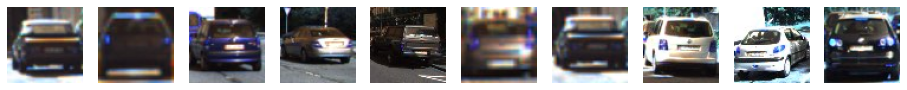

Imágenes donde no hay autos:


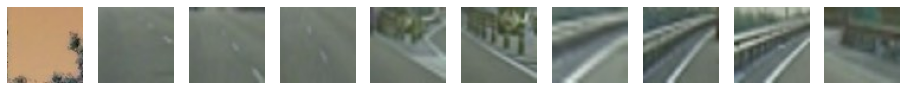

In [5]:
print("Imágenes donde hay autos:")
plt.subplots(1,10,figsize=(16,16))
for i in range(10):
    Itmp = cv2.imread(names_cars[i])
    plt.subplot(1,10,i+1); plt.axis('off'); plt.imshow(Itmp)
plt.show()
    
print("Imágenes donde no hay autos:")
plt.subplots(1,10,figsize=(16,16))
for i in range(10):
    Itmp = cv2.imread(names_notcars[i])
    plt.subplot(1,10,i+1); plt.axis('off'); plt.imshow(Itmp)
plt.show()

Se extrae las características de cada imagen, las cuales están constituidas por histogramas HSV normalizados

In [6]:
hist_bins = 32
hist_range = (0, 256)

# Extraer características hsv
car_features = extract_hsv_features(names_cars, hist_bins, hist_range)
notcar_features = extract_hsv_features(names_notcars, hist_bins, hist_range)

# Crear un arreglo bidimensional con los vectores característica  (Tamaño debe ser 2321x96)
X = np.vstack((car_features, notcar_features))      

# Definir arreglo unidimensional de etiquetas con 1 para autos, 0 para otros
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

Escalar cada atributo sustrayendo su media y dividiendo entre la desviación estándar. Se puede realizar manualmente o utilizar [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [7]:
# Generar un escalador con la media y la desviación estándar
X_scaler = StandardScaler().fit(X)
# Aplicar el escalador a los datos X
Xscaled = X_scaler.transform(X)

Dividir los datos de manera aleatoria en dos conjuntos: uno para entrenamiento (train) y otro para prueba (test). Mostrar el tamaño de los conjuntos obtenidos (a modo de verificación)

In [8]:
# Indices
idx = np.arange(len(y))

Xtrain, Xtest, ytrain, ytest, idxtrain, idxtest = train_test_split(Xscaled, y, idx, test_size=0.2, random_state=0)

print('El conjunto de datos contiene {} autos y {} imágenes que no son autos'.format(len(names_cars), len(names_notcars)))
print('Cada vector de características (histograma HSV) tiene {} elementos'.format(hist_bins*3))

print('El tamaño de los datos X de entrenamiento (Xtrain) es:', Xtrain.shape)
print('El tamaño de las datos X de prueba (Xtest) es:', Xtest.shape)

El conjunto de datos contiene 1196 autos y 1125 imágenes que no son autos
Cada vector de características (histograma HSV) tiene 96 elementos
El tamaño de los datos X de entrenamiento (Xtrain) es: (1856, 96)
El tamaño de las datos X de prueba (Xtest) es: (465, 96)


## 2. Entrenamiento

Utilizar algún método de entrenamiento (como SVM) para el conjunto de datos de entrenamiento)

In [9]:
# Usar un SVM lineal
svm = SVC(kernel='linear');
# Entrenamiento
svm.fit(Xtrain, ytrain);

Calcular la exactitud en el conjunto de entrenamiento

In [10]:
# Exactitud en el conjunto de entrenamiento
ytrain_predicted = svm.predict(Xtrain)
acc_train = accuracy_score(ytrain_predicted, ytrain)

print('Exactitud en el conjunto de entrenamiento para SVM lineal:', round(acc_train, 4))

Exactitud en el conjunto de entrenamiento para SVM lineal: 0.9989


Obtener la matriz de confusión para el conjunto de entrenamiento, e indicar el número de falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos. Se puede utilizar la función [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) de scikit-learn.

In [11]:
# Se comparan los resultados predichos con los reales a través de una matriz de confusión, la cual
# muestra los valores de los True Positive, False Positive, False Negative, y True Negative, respectivamente.
confusion_matrix(ytrain, ytrain_predicted)

array([[909,   1],
       [  1, 945]], dtype=int64)

## 3. Prueba

Realizar predicciones sobre el conjunto de prueba y calcular la exactitud en el conjunto de prueba

In [12]:
# Exactitud en el conjunto de prueba
ytest_predicted = svm.predict(Xtest)
acc_test = accuracy_score(ytest_predicted, ytest)
print('Exactitud en el conjunto de prueba para SVM lineal:', round(acc_test, 4))

Exactitud en el conjunto de prueba para SVM lineal: 0.9806


Mostrar algunas imágenes (de preferencia correspondientes al conjunto de prueba) junto con los valores que se predice para dichas imágenes (si es auto o si no es auto)

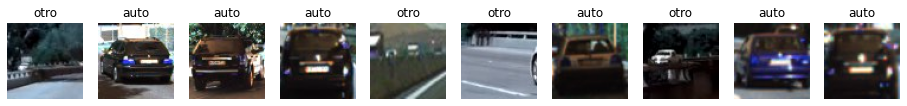

In [13]:
# Predicción para algunas imágenes
n = 10   # Número de predicciones
index = np.random.randint(len(ytest), size=n)
ypred = svm.predict(Xtest[index])

# Nombres de todas las imágenes
names = names_cars+names_notcars
# Diccionario
label = {0:'otro', 1:'auto'}

# Gráfico
plt.subplots(1,n,figsize=(16,16))
for i in range(n):
    Itmp = cv2.imread(names[idxtest[index[i]]])
    plt.subplot(1,10,i+1); plt.axis('off'); plt.title(label[ypred[i]])
    plt.imshow(Itmp)
plt.show()